<a href="https://colab.research.google.com/github/SLVmain/ITMO_DL_in_practice_01/blob/main/f_2_3_yolo5S_plates_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [1]:
!nvidia-smi

Tue Oct  4 23:22:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# загружаем easyocr-1.6.2-py3
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 27.9 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 120 kB 68.5 MB/s 
     |████████████████████████████████| 604 kB 63.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [3]:
#после установки restart!!!
!pip install git+https://github.com/JaidedAI/EasyOCR.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JaidedAI/EasyOCR.git to /tmp/pip-req-build-8sqhdv9n
  Running command git clone -q https://github.com/JaidedAI/EasyOCR.git /tmp/pip-req-build-8sqhdv9n


загружаем ридер ocr на русском и английском, так как так лучше определяет

In [4]:
import easyocr
reader = easyocr.Reader(['ru','en']) # загрузка только один раз

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

### Распознавание на фото

In [13]:
#загрузка модели с яндекс-диска
!wget -O /content/best.zip https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/qlsemOEd-hsfsQ


--2022-10-04 23:26:17--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/qlsemOEd-hsfsQ
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/76f075a9d75063e52a28334032a717cf45515ba0e3cd6d3e0daf6feaa9d07a84/633cf8c8/4CujTZRyfM_ezz2E84iKKLJUyrspkhnoiifo1l-QNJcXcE9zV1TPHHaO9YGbapRBnKn-8RHuTDCr8tUbPugFdg%3D%3D?uid=0&filename=best.onnx.zip&disposition=attachment&hash=T3A6%2BKnufWbAdZ/O6j1C9W/MvTp/kgJSbwQ6PiwzixrMNKXGs5oTygTwABA/KEViq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=6709741&fsize=147541046&hid=47a892a4b8ca284d71dae248d66ff852&media_type=compressed&tknv=v2 [following]
--2022-10-04 23:26:18--  https://downloader.disk.yandex.ru/disk/76f075a9d75063e52a28334032a717cf45515ba0e3cd6d3e0daf6feaa9d07a84/633cf8c8/4CujTZRyfM_ezz2E84iKKLJUyrsp

In [7]:
#загрузка тестового фото
!wget -O /content/test_img.jpg https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/bsOxbpUXkhTDPQ


--2022-10-04 23:24:05--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/bsOxbpUXkhTDPQ
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/b279ba0d7f52eb3453bff3704c4fe86160dd37177482325486f4cb39d64dcfe5/633cf8d6/mbPVMceusqeba6ly7DlR-CApXBLZllHwJI9GVtv93C6OLRrf2AZjLTeUCxyvHC3jF1V_XamUbTtfFGKbpRGB_g%3D%3D?uid=0&filename=303.jpeg&disposition=attachment&hash=Ig7NwN68TJ/M5l1924q7YnSUkCTIUL%2B8w78dGBVtnH0L39hyq8qVI/ZFZA2VFgehq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=image%2Fjpeg&owner_uid=6709741&fsize=379357&hid=ba72a123873a1e303e372e4549c14e6e&media_type=image&tknv=v2 [following]
--2022-10-04 23:24:06--  https://downloader.disk.yandex.ru/disk/b279ba0d7f52eb3453bff3704c4fe86160dd37177482325486f4cb39d64dcfe5/633cf8d6/mbPVMceusqeba6ly7DlR-CApXBLZllHwJI9GVtv93C6OLR

In [8]:
#загрузка тестового видео
!wget -O /content/test_v.mp4 https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/MU-N1FH4Okqwdw

--2022-10-04 23:24:16--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/MU-N1FH4Okqwdw
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/dae8362de6076f2002e67c819e96fb6bbbea22151650e45d13b5fd8d671b6a99/633cf8e1/4CujTZRyfM_ezz2E84iKKJcoVNw55_qsuGnVY8XRKzSYKcJ2DgcYDwUsVp1rn5NqmNdcXavJWUN61lXEBbFy4Q%3D%3D?uid=0&filename=test_video1.mp4&disposition=attachment&hash=NyEia4p8cxS6875TZX%2BZSX3jvrg/H/lPdGmHuKj4J8%2BsUXLCIGMR0MjkSG7SZSqZq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=video%2Fmp4&owner_uid=6709741&fsize=5428518&hid=114511211cfe1afc22e5bc4a5b86d56d&media_type=video&tknv=v2 [following]
--2022-10-04 23:24:17--  https://downloader.disk.yandex.ru/disk/dae8362de6076f2002e67c819e96fb6bbbea22151650e45d13b5fd8d671b6a99/633cf8e1/4CujTZRyfM_ezz2E84iKKJcoVNw55_qsuGnVY

In [14]:
!unzip /content/best.zip

Archive:  /content/best.zip
replace best.onnx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: best.onnx               
  inflating: __MACOSX/._best.onnx    


In [15]:
model_path = '/content/best.onnx'

image_path = '/content/test_img.jpg'

video_path = '/content/test_v.mp4'

In [10]:
# константы
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

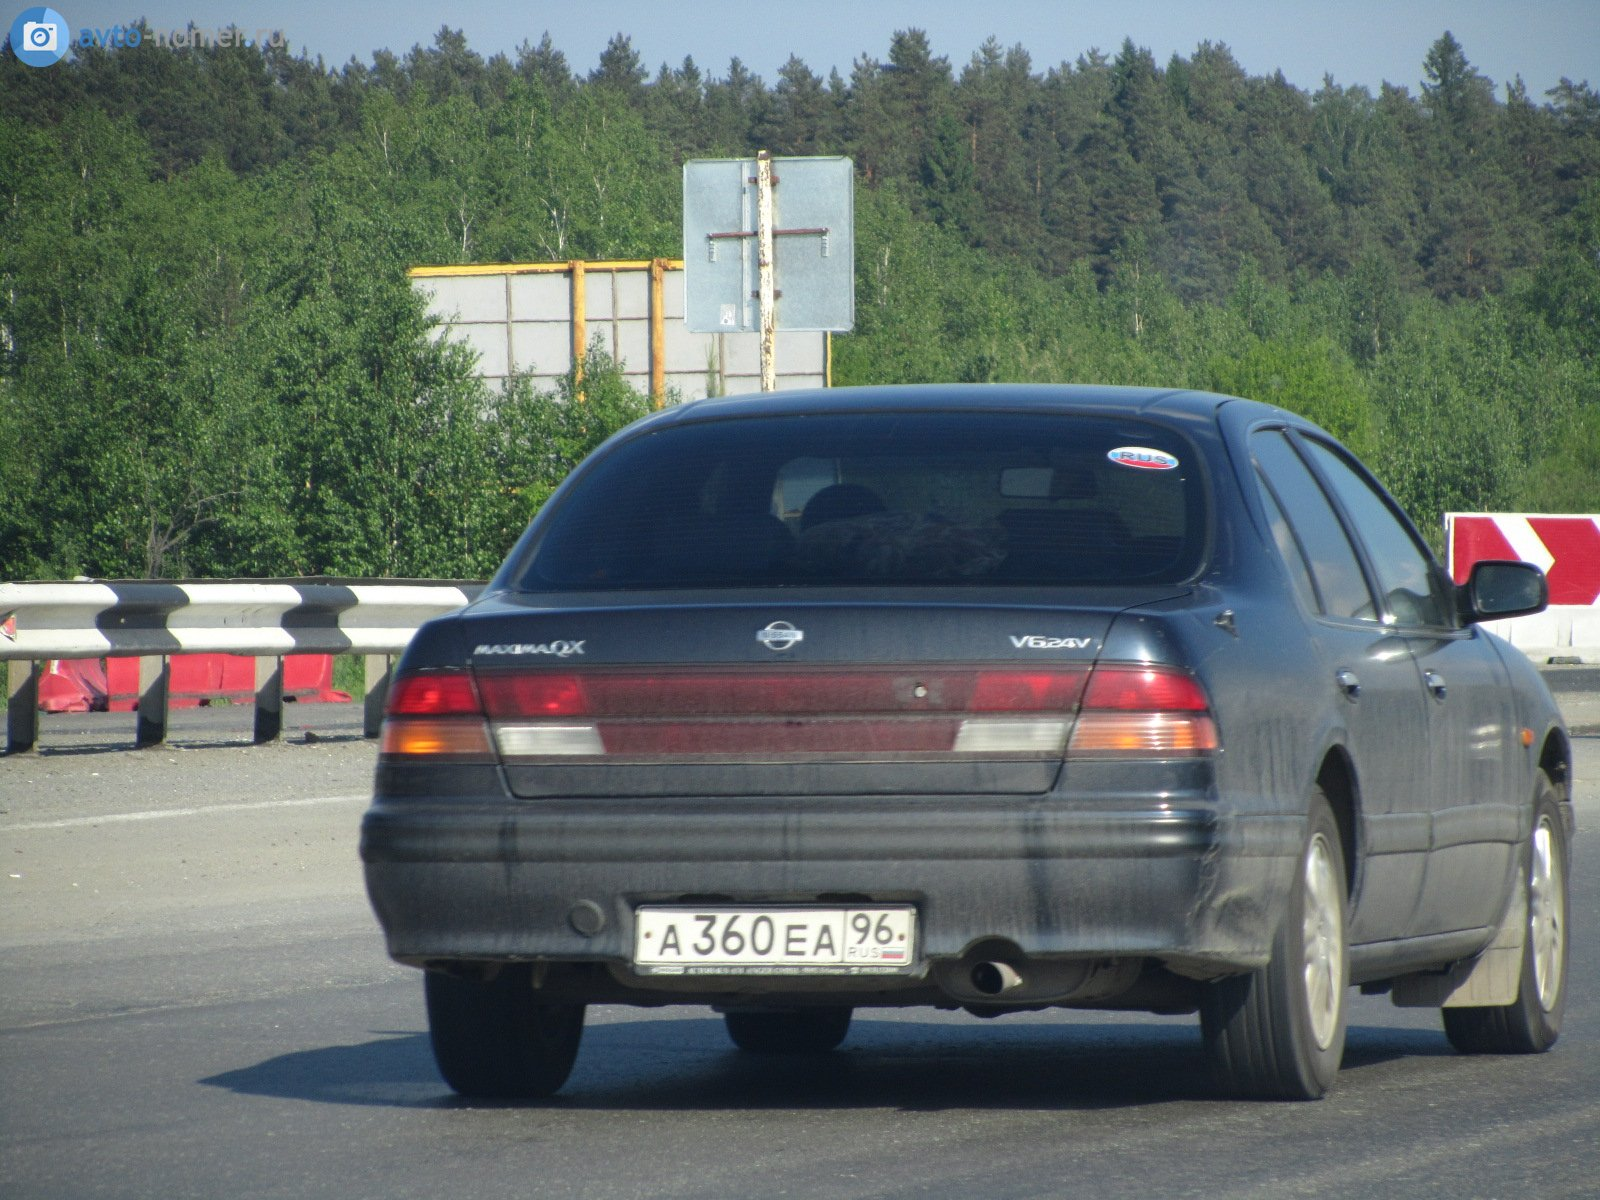

In [11]:
# Загрузка тестовой картинки

img = cv2.imread(image_path)

cv2_imshow(img)

In [16]:
# загрузка YOLO модели
net = cv2.dnn.readNetFromONNX(model_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [17]:
def get_detections(img,net):
    # конвертация фото в формат yolo
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # получаем предсказание от yolo
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    # фильтруем предсказания по уверенности и вероятности класса
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # уверенность детекции номера
        if confidence > 0.4:
            class_score = row[5] # уверенность определении класса
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # очистка
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # Non Maximum Supression
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten()
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # отрисовка
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text_easy(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_COMPLEX,0.7,(0,255,0),1) #шрифт кириллица!!!

    return image

In [18]:
# предсказание
def yolo_predictions(img,net):
    ## шаг-1: детекция
    input_image, detections = get_detections(img,net)
    ## шаг-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    ## шаг-3: отрисовка
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [19]:
def extract_text_easy(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h+3, x:x+w+3]
    
    if 0 in roi.shape:
        return ''
    
    else:
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) #конвертация в чб
        roi = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 39,  14) #бинарный порог
        text = reader.readtext(roi, detail=0)
        text = ''.join(map(str,text))
        text = text.strip().upper()
        text = ''.join(e for e in text if e.isalnum())
        
        return text

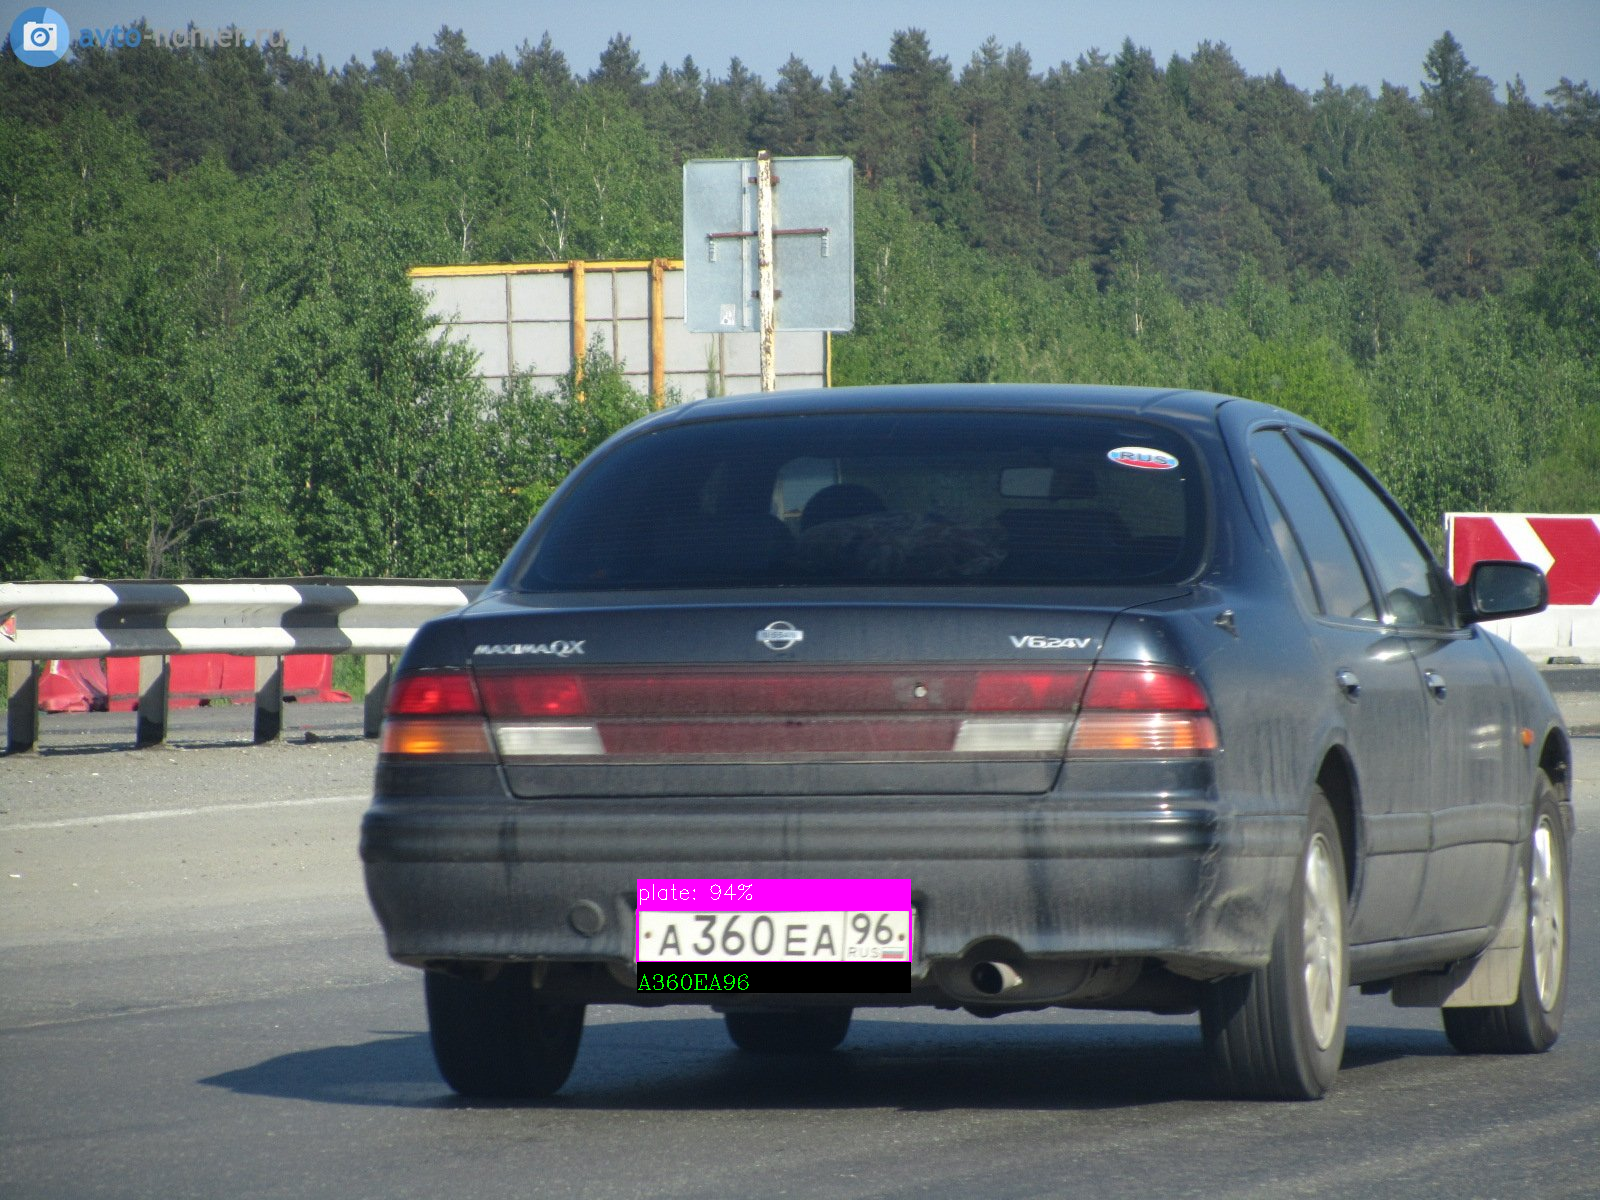

In [20]:
# test
img = cv2.imread(image_path)

results = yolo_predictions(img,net)
cv2_imshow(results)

### Real Time Object Detection

In [26]:
video = cv2.VideoCapture(video_path)


print(video.get(cv2.CAP_PROP_FPS))

25.0


In [ ]:
#пишется полчаса!
video = cv2.VideoCapture(video_path)


fps = video.get(cv2.CAP_PROP_FPS)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

output = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))

for frame_num in tqdm(range(nframes)):

    #if frame_num % ratio == 0: #каждый шестой кадр 
    ret, frame = video.read()
    
    if ret == False:
        print('unable to read video')
        break
        
    try:
      results = yolo_predictions(frame,net)
    
    except:
      pass  #frame писать тогда
    
    output.write(results)
    
        
video.release()
output.release()   

  0%|          | 33/10075 [01:15<6:20:36,  2.27s/it]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/drive/MyDrive/DL_ITMO/results/output2.mp4"

# Compressed video path
compressed_path = "/content/drive/MyDrive/DL_ITMO/results/result_compressed.mp4"

#os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)